<a href="https://colab.research.google.com/github/Dicti93/MLSEM/blob/master/5.%20Modelling/CNN_MLAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import itertools
import gc
import copy
import re

from PIL import Image
from tabulate import tabulate
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix
from collections import defaultdict, Counter
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, default_collate

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 230)  # Set the maximum width of the display

In [3]:
# !wget -O US_Pictures.zip https://zenodo.org/records/7669442/files/US_Pictures.zip
# !unzip -q US_Pictures.zip -d /content/US_Pictures/
# image_path = '/content/US_Pictures/'
# print(os.listdir(image_path))

image_path = '/content/drive/My Drive/CNN/US_Pictures/'
print(os.listdir(image_path))

['185.4 App_M.bmp', '525.3 App_M.bmp', '266.1 App_M.bmp', '178.2 App_M.bmp', '76.3 App L.bmp', '747.3 App_M.bmp', '22.3 Appendix transv. target sign.bmp', '102.5 App_M.bmp', '814.5 App_M.bmp', '601.4 App_M.bmp', '863.1 App.bmp', '103.5 App.bmp', '911.2 RLQ_M.bmp', '900.4 App_M.bmp', '928.3 App_M.bmp', '927.10 App.bmp', '546.1 App.bmp', '23.2 Appendix.bmp', '861.3 App_M.bmp', '939.1 RLQ app not vis.bmp', '125.3 App_M.bmp', '792.4 App_M.bmp', '29.3 Appendix transv.bmp', '65.1 App T.bmp', '176.1 App_M.bmp', '645.3 App_M.bmp', '401.1 App_M.bmp', '850.1 App.bmp', '130.3 App_M.bmp', '524.1 App_M.bmp', '636.4 App_M.bmp', '870.1 App_M.bmp', '338.1 RLQ app not visible.bmp', '924.3 App_M.bmp', '111.1 App_D.bmp', '589.1 App_D.bmp', '221.1 RLQ.bmp', '645.5 App_M.bmp', '29.1 Appendix and surrounding free fluids.bmp', '108.2 App_M.bmp', '836.3 App_M.bmp', '128.1 App_M.bmp', '814.3 App_M.bmp', '528.1 App_M.bmp', '827.1 App.bmp', '678.2 App_M.bmp', '82.1 LAM RLQ_app not visible.bmp', '158.1 App_M.bmp'

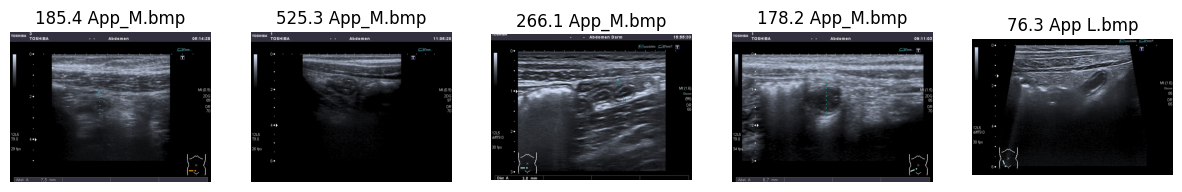

In [4]:
def display_images(image_path, num_images=5):
    # Ensure the function handles no image files gracefully
    files = [f for f in os.listdir(image_path) if f.endswith(('.png', '.bmp'))][:num_images]
    if not files:
        print("No image files found in the directory.")
        return

    fig, axs = plt.subplots(1, len(files), figsize=(15, 5))
    for i, file in enumerate(files):
        img = Image.open(os.path.join(image_path, file))
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(file)
    plt.show()

display_images(image_path)

In [5]:
# Load the data
data_url = "https://raw.githubusercontent.com/Dicti93/MLSEM/master/2.%20Data%20and%20Description/data.csv"
tabular_data = pd.read_csv(data_url, delimiter= ';')

# Removing not needed target variables from data
data = tabular_data.drop(['Age', 'BMI', 'Sex', 'Height', 'Weight', 'Length_of_Stay', 'Management',
                          'Severity', 'Diagnosis_Presumptive', 'Alvarado_Score', 'Paedriatic_Appendicitis_Score',
                          'Appendix_on_US', 'Appendix_Diameter', 'Migratory_Pain', 'Lower_Right_Abd_Pain',
                          'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea', 'Loss_of_Appetite',
                          'Body_Temperature', 'WBC_Count', 'Neutrophil_Percentage', 'Segmented_Neutrophils',
                          'Neutrophilia', 'RBC_Count', 'Hemoglobin', 'RDW', 'Thrombocyte_Count', 'Ketones_in_Urine',
                          'RBC_in_Urine', 'WBC_in_Urine', 'CRP', 'Dysuria', 'Stool', 'Peritonitis',
                          'Psoas_Sign', 'Ipsilateral_Rebound_Tenderness', 'US_Performed', 'Free_Fluids',
                          'Appendix_Wall_Layers', 'Target_Sign', 'Appendicolith', 'Perfusion', 'Perforation',
                          'Surrounding_Tissue_Reaction', 'Appendicular_Abscess', 'Abscess_Location',
                          'Pathological_Lymph_Nodes', 'Lymph_Nodes_Location', 'Bowel_Wall_Thickening',
                          'Conglomerate_of_Bowel_Loops', 'Ileus', 'Coprostasis', 'Meteorism', 'Enteritis',
                          'Gynecological_Findings', 'Unnamed: 58', 'Unnamed: 59', 'Unnamed: 60','Unnamed: 61',
                          'Unnamed: 62', 'Unnamed: 63', 'Unnamed: 64', 'Unnamed: 65', 'Unnamed: 66','Unnamed: 67',
                          'Unnamed: 68'], axis=1)

# Mapping 'Diagnosis' to binary and handling missing values
data["Diagnosis"] = data["Diagnosis"].replace({'appendicitis': 1, 'no appendicitis': 0, })
data['Diagnosis'] = data['Diagnosis'].replace({np.nan: 0})

# Removing rows with NaN in 'US_Number' and converting columns to integer
data = data.dropna(subset=['US_Number'])
data['US_Number'] = data['US_Number'].astype(int)
data['Diagnosis'] = data['Diagnosis'].astype(int)

# Print the data to verify the conversion
print(data.head())

# Creating id_to_label and ensuring keys are strings
id_to_label = {int(row['US_Number']): row['Diagnosis'] for index, row in data.iterrows() if pd.notna(row['US_Number'])}

print(id_to_label)

   Diagnosis  US_Number
0          1        882
1          0        883
2          0        884
3          0        886
4          1        887
{882: 1, 883: 0, 884: 0, 886: 0, 887: 1, 888: 0, 889: 0, 890: 0, 891: 0, 893: 1, 894: 1, 895: 0, 896: 0, 897: 0, 900: 1, 903: 0, 904: 1, 905: 1, 909: 1, 910: 0, 911: 1, 913: 0, 914: 0, 916: 0, 917: 0, 918: 1, 921: 1, 922: 0, 924: 1, 925: 1, 926: 0, 927: 1, 928: 1, 929: 0, 930: 1, 931: 0, 933: 1, 934: 0, 935: 1, 936: 1, 938: 1, 939: 1, 940: 0, 942: 0, 943: 0, 945: 0, 946: 0, 947: 1, 948: 0, 949: 0, 950: 1, 951: 0, 952: 0, 953: 1, 954: 0, 955: 1, 959: 0, 961: 0, 962: 0, 963: 0, 965: 1, 967: 0, 968: 0, 971: 0, 973: 1, 974: 1, 976: 0, 977: 0, 978: 0, 981: 1, 982: 0, 983: 0, 986: 0, 988: 0, 989: 1, 991: 0, 992: 1, 733: 1, 735: 1, 736: 0, 737: 0, 738: 1, 739: 0, 740: 1, 743: 0, 745: 0, 746: 1, 748: 1, 749: 1, 750: 1, 751: 1, 752: 1, 753: 0, 754: 0, 755: 0, 756: 1, 757: 0, 759: 1, 760: 0, 761: 1, 765: 0, 769: 0, 771: 1, 772: 1, 775: 1, 777: 1, 779: 0,

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # Input channels = 3 (RGB), output channels = 16
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer
        self.fc1 = nn.Linear(64 * 32 * 32, 512)  # Adjust the input features to match image size
        self.fc2 = nn.Linear(512, 2)  # Output layer: adjust according to the number of classes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = torch.flatten(x, 1)  # Flatten all dimensions except the batch
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (relu): ReLU()
)


In [7]:
class MedicalImagesDataset(Dataset):
    def __init__(self, root_dir, labels_dict, transform=None, augment=False):
        """
        Args:
            root_dir (string): Directory with all the image files.
            labels_dict (dict): Dictionary mapping image file names to labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.labels_dict = labels_dict
        self.transform = transform
        self.augment = augment
        self.filename_mapping = {}
        self.unique_us_numbers = set()
        self.diagnosis_count_per_image = defaultdict(int)
        self.augmented_count_per_image = defaultdict(int)
        self.num_images_found = 0
        table_data = []

# This section handles image loading, transformation, and optional augmentation.
        # Create a mapping between full filenames and image data
        for filename in os.listdir(root_dir):
            self.num_images_found += 1
            try:
                base_name = filename.split(' ')[0]  # Extract the numeric prefix
                match = re.match(r"([0-9]+(?:\.[0-9]+)?)", base_name)
                base_name = match.group(1)
                image_number = int(base_name.split('.')[0])  # Convert to float to handle decimals
                # Use the image number as a key to get the corresponding label from labels_dict
                label = labels_dict.get(image_number)

                if label is not None:  # Only proceed if a valid label exists
                    self.unique_us_numbers.add(image_number)
                    self.diagnosis_count_per_image[label] += 1  # Increment the count for the diagnosis
                    image = Image.open(os.path.join(root_dir, filename)).convert('RGB')

# Apply initial transformation and handle class-specific augmentation.
                    # Store the tensor along with the full filename
                    if self.transform:
                        processed_image = self.transform(image)
                    self.filename_mapping[base_name] = (processed_image, label)
                    self.unique_us_numbers.add(image_number)
                    table_data.append((image_number, base_name, label, type(image_number)))

                    if self.augment:
                      times = 3 if label == 0  else 0
                      augmented_images = self.augment_image(image, times, base_name)
                      for aug_filename, aug_image in augmented_images.items():
                          self.filename_mapping[aug_filename] = (aug_image, label)
                          self.augmented_count_per_image[label] += 1

# Exception handling for files with unexpected naming conventions enhances robustness.
            except ValueError:
                # This handles cases where the filename does not start with an integer
                print(f"Skipping file with non-standard naming: {filename}")

        # Sort the table data by the "Image Number" column
        sorted_table_data = sorted(table_data, key=lambda x: x[0])

        # Print the sorted table using tabulate after iterating over all images
        # print(tabulate(sorted_table_data, headers=['Image Number', 'Filename', 'Diagnosis', 'Type']))
        self.print_dataset_statistics()

# Compute and display dataset statistics to verify correct processing and balance.
    def print_dataset_statistics(self):
        print(f"Total images found before matching: {self.num_images_found}")
        print(f"Total us_numbers successfully mapped to images: {len(self.unique_us_numbers)}")
        print(f"Total images successfully mapped to a US_NUMBER: {len(self.filename_mapping)}")
        print(f"Original images: {sum(self.diagnosis_count_per_image.values())}")
        print(f"Augmented images: {sum(self.augmented_count_per_image.values())}")

        for label, count in self.diagnosis_count_per_image.items():
            aug_count = self.augmented_count_per_image[label]
            total_count = count + aug_count
            ratio = aug_count / float(count) if count != 0 else 0
            print(f"Label {label}: Original {count}, Augmented {aug_count}, Total {total_count}, Ratio {ratio:.2f}")

# Dynamic image augmentation based on a predefined set of possible transformations.
    def augment_image(self, image, times, original_filename):
    # All possible transformations
        possible_transformations = [
            lambda x: TF.rotate(x, -10),  # Rotate by various degrees
            lambda x: TF.rotate(x, -5),   # Rotate by various degrees
            lambda x: TF.rotate(x, 5),    # Rotate by various degrees
            lambda x: TF.rotate(x, 10),   # Rotate by various degrees
            lambda x: TF.affine(x, translate=(0.1, 0.1), scale=1.05, angle=0, shear=0),   # Enlargement
            lambda x: TF.affine(x, translate=(0.1, 0.1), scale=1.1, angle=0, shear=0),    # Enlargement
            lambda x: TF.affine(x, translate=(-0.1, -0.1), scale=0.95, angle=0, shear=0), # Shrinking
            lambda x: TF.affine(x, translate=(-0.1, -0.1), scale=0.9, angle=0, shear=0),  # Shrinking
            lambda x: TF.affine(x, angle=0, translate=(0, 0), scale=1.0, shear=5),        # Shearing
        ]

        # Ensure we do not pick more transformations than available
        num_transforms = min(len(possible_transformations), times)
        # Select unique transformations without replacement
        selected_transforms = random.sample(possible_transformations, num_transforms)
        augmented_images = {}
        for i, transform in enumerate(selected_transforms):
            if self.transform:
                aug_image = self.transform(image)  # Additional transformations like normalization
            augmented_images[f"{original_filename}_{i+1}"] = aug_image

        return augmented_images

# Standard dataset methods for PyTorch compatibility.
    def __len__(self):
        return len(self.filename_mapping)

    def __getitem__(self, idx):
        # Retrieve the data point using the filename mapping
        filename = list(self.filename_mapping.keys())[idx]
        image, label = self.filename_mapping[filename]
        return image, label, filename

In [8]:
# Define image transformations to standardize and normalize images for consistent model input.
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizse
])
# Initialize the dataset with the specified directory, label mappings, transformations, and augmentation enabled.
dataset = MedicalImagesDataset(image_path, id_to_label, transform, augment=True)

Total images found before matching: 2097
Total us_numbers successfully mapped to images: 579
Total images successfully mapped to a US_NUMBER: 2882
Original images: 1727
Augmented images: 1164
Label 1: Original 1339, Augmented 0, Total 1339, Ratio 0.00
Label 0: Original 388, Augmented 1164, Total 1552, Ratio 3.00


In [9]:
# Print first entries of the dataset to inspect their structure
for idx in range(1):
    print(dataset[idx])

(tensor([[[-1.2445, -1.2445, -1.2445,  ..., -1.2445, -1.2445, -1.2445],
         [-1.2445, -1.2445, -1.2445,  ..., -1.2445, -1.2445, -1.2445],
         [-1.2445, -1.2445, -1.2445,  ..., -1.2445, -1.2445, -1.2445],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-1.1779, -1.1779, -1.1779,  ..., -1.1779, -1.1779, -1.1779],
         [-1.1779, -1.1779, -1.1779,  ..., -1.1779, -1.1779, -1.1779],
         [-1.1779, -1.1779, -1.1779,  ..., -1.1779, -1.1779, -1.1779],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-0.7064, -0.7064, -0.7064,  ..., -0.7064, -0.7064, -0.7064],
         [-0.7064, -0.7064, -0.7064,  ..., -

In [45]:
# filename_mapping_copy = copy.deepcopy(dataset.filename_mapping)
# labels_dict_copy = copy.deepcopy(dataset.labels_dict)
# filename_mapping_copy = dataset.filename_mapping
# labels_dict_copy = dataset.labels_dict
# Initialize a dictionary to count images per US_NUMBER
image_counts = defaultdict(int)

# Extract and count images
for filename in filename_mapping_copy:
    try:
        us_number = int(filename.split('.')[0])
        image_counts[us_number] += 1
    except ValueError as e:
        print(f"Skipping filename with parsing issue: {filename}. Error: {e}")

# Dictionary for reassigning labels and renaming images, and set threshold
reassigned_filenames = {}
reassigned_labels = {}
threshold = 8
# this has to be done twice in a loop ****
# Reassigning process
for us_number, count in image_counts.items():
    if count > threshold:
        excess_count = count - threshold
        if excess_count > 0:
            sorted_filenames = sorted(
                [fn for fn in filename_mapping_copy if int(fn.split('.')[0])==us_number],
                key=lambda x: int(x.rsplit('_', 1)[-1]) if '_' in x and x.split('_')[1].isdigit() else 0,
                reverse=True
            )
            for filename in sorted_filenames:
                if excess_count > 0 and '_' in filename:
                    new_us_number = int(f"1000{us_number}")
                    original_label = labels_dict_copy.get(us_number)
                    new_filename = filename.replace(str(us_number), str(new_us_number))
                    reassigned_filenames[new_filename] = filename_mapping_copy.pop(filename)
                    reassigned_labels[new_filename] = original_label
                    labels_dict_copy[new_us_number] = original_label
                    excess_count -= 1
                    print(f"Reassigned {filename} to {new_filename}")
                    if excess_count <= 0:
                        break

# Updating mappings and recalculating counts
filename_mapping_copy.update(reassigned_filenames)

# Recalculate counts and prepare for output
new_image_counts = defaultdict(int)
for filename in filename_mapping_copy:
    us_number = int(filename.split('.')[0])
    new_image_counts[us_number] += 1

# Prepare data for tabulation
table_data = [
    [us_number, image_counts[us_number], new_image_counts[us_number], labels_dict_copy.get(us_number)]
    for us_number in sorted(new_image_counts)
]

# Print the final table
print(tabulate(table_data, headers=["US_NUMBER", "Old Count", "New Count", "Label"], tablefmt="grid"))

dataset.filename_mapping.update(filename_mapping_copy)
dataset.labels_dict.update(labels_dict_copy)

+-------------------------+-------------+-------------+---------+
|               US_NUMBER |   Old Count |   New Count |   Label |
+=========================+=============+=============+=========+
|                       1 |           8 |           8 |       0 |
+-------------------------+-------------+-------------+---------+
|                       3 |           8 |           8 |       0 |
+-------------------------+-------------+-------------+---------+
|                       4 |           2 |           2 |       1 |
+-------------------------+-------------+-------------+---------+
|                       5 |           8 |           8 |       0 |
+-------------------------+-------------+-------------+---------+
|                       6 |           4 |           4 |       1 |
+-------------------------+-------------+-------------+---------+
|                       7 |           4 |           4 |       0 |
+-------------------------+-------------+-------------+---------+
|         

In [46]:
# Custom collate function
def custom_collate(batch):
    images = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    filenames = [item[2] for item in batch]

    # Find the maximum sequence length in the batch
    max_sequence_length = max(len(image) for image in images)

    # Pad images to the same size
    padded_images = []
    for image_sequence in images:
        num_padding = max_sequence_length - len(image_sequence)
        padded_sequence = torch.nn.functional.pad(image_sequence, (0, num_padding))
        padded_images.append(padded_sequence)

    # Stack padded images
    stacked_images = torch.stack(padded_images)

    return stacked_images, torch.tensor(labels), filenames

In [47]:
us_numbers = []
labels = []

# Loop over each entry in the filename mapping
for filename, (image, label) in dataset.filename_mapping.items():
    image_number = int(filename.split('.')[0])
    us_numbers.append(image_number)
    labels.append(label)

# Convert lists to numpy arrays for proper indexing
us_numbers = np.array(us_numbers)
labels = np.array(labels)

# Create the splitter
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Get indices for the splits
train_inds, val_inds = next(gss.split(X=labels, groups=us_numbers))

# Extract datasets for training and validation using list comprehension
train_dataset = [dataset[i] for i in train_inds]
val_dataset = [dataset[i] for i in val_inds]

# Create DataLoader for both training and validation sets
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=80, shuffle=False, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=80, shuffle=False, collate_fn=custom_collate)


In [48]:
# Collect filenames and labels from train_dataset
train_filenames = [filename for _, label, filename in train_dataset]
train_labels = [label for _, label, filename in train_dataset]

# Collect filenames and labels from val_dataset
val_filenames = [filename for _, label, filename in val_dataset]
val_labels = [label for _, label, filename in val_dataset]

# Create DataFrames
train_df = pd.DataFrame({'Filename': train_filenames, 'Label': train_labels})

val_df = pd.DataFrame({'Filename': val_filenames, 'Label': val_labels})

# Sort by Filename
train_df_sorted = train_df.sort_values(by='Filename', ascending=True)
val_df_sorted = val_df.sort_values(by='Filename', ascending=True)

# print("Sorted Training Data:")
# print(train_df_sorted)
# print("\nSorted Validation Data:")
# print(val_df_sorted)

In [51]:
# Count occurrences of each diagnosis in the training set
train_diagnosis_counts = train_df_sorted['Label'].value_counts()

# Count occurrences of each diagnosis in the validation set
val_diagnosis_counts = val_df_sorted['Label'].value_counts()

# Print the counts
print("Diagnosis Distribution in Training Data:")
print(train_diagnosis_counts)
print("\nDiagnosis Distribution in Validation Data:")
print(val_diagnosis_counts)

Diagnosis Distribution in Training Data:
Label
0    1269
1    1038
Name: count, dtype: int64

Diagnosis Distribution in Validation Data:
Label
0    302
1    300
Name: count, dtype: int64


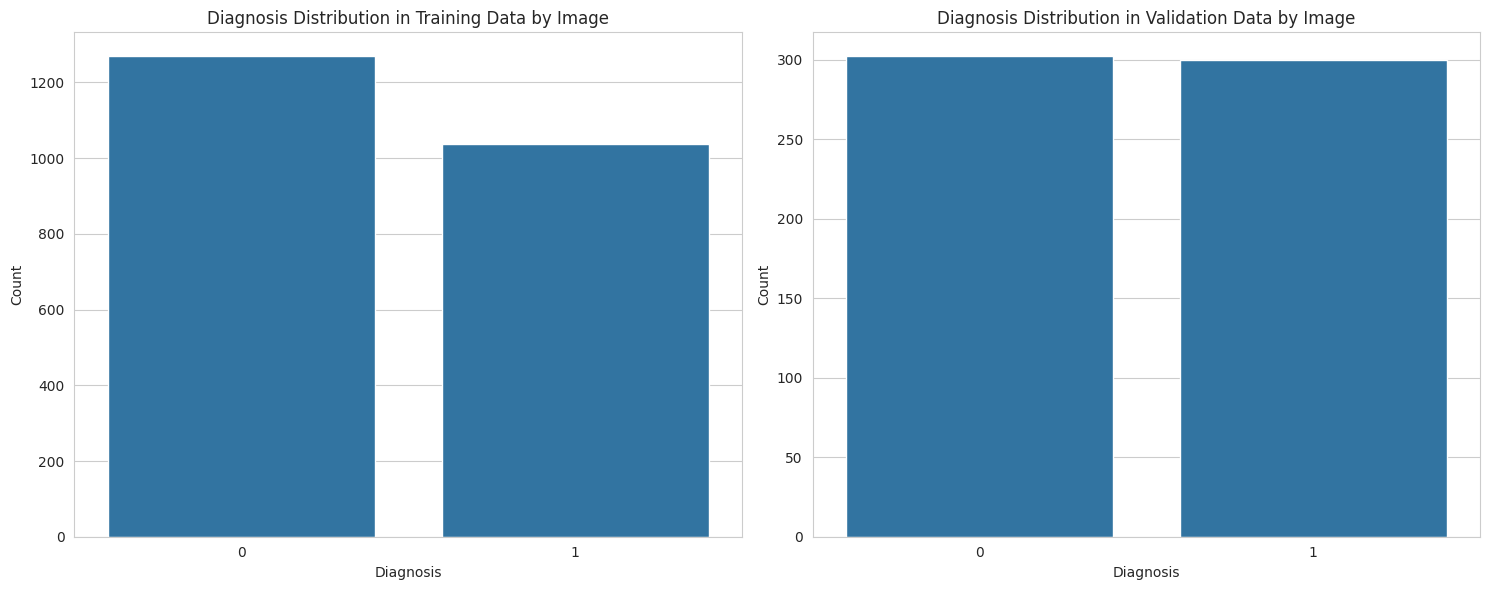

In [52]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # Adjust figsize as needed

# Plot for Training Data
sns.countplot(x='Label', data=train_df_sorted, ax=axs[0])
axs[0].set_title('Diagnosis Distribution in Training Data by Image')
axs[0].set_xlabel('Diagnosis')
axs[0].set_ylabel('Count')

# Plot for Validation Data
sns.countplot(x='Label', data=val_df_sorted, ax=axs[1])
axs[1].set_title('Diagnosis Distribution in Validation Data by Image')
axs[1].set_xlabel('Diagnosis')
axs[1].set_ylabel('Count')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

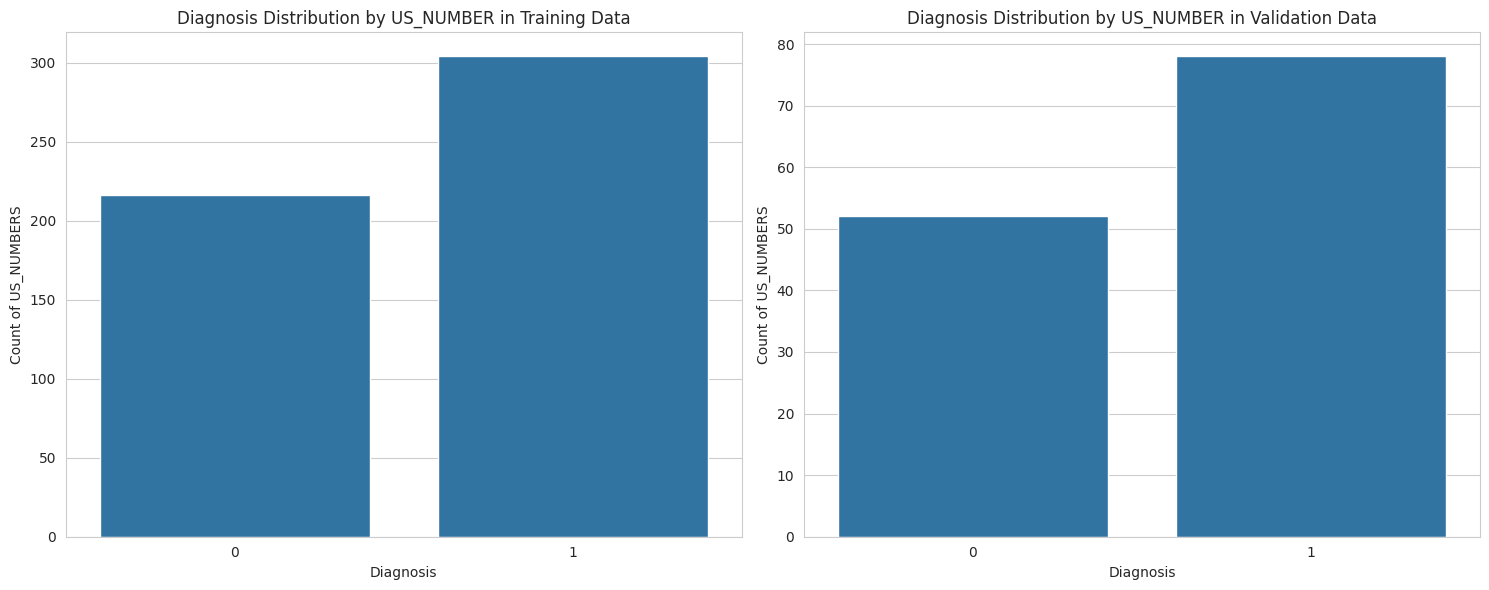

In [53]:
# Function to extract US_NUMBER from Filename
def extract_us_number(filename):
    return int(filename.split('.')[0])

# Apply the function to train and validation DataFrames
train_df_sorted['US_NUMBER'] = train_df_sorted['Filename'].apply(extract_us_number)
val_df_sorted['US_NUMBER'] = val_df_sorted['Filename'].apply(extract_us_number)

# Aggregate by US_NUMBER and get the most frequent Label for cases of multiple images per US_NUMBER
train_diagnosis = train_df_sorted.groupby('US_NUMBER')['Label'].agg(lambda x: x.mode()[0])
val_diagnosis = val_df_sorted.groupby('US_NUMBER')['Label'].agg(lambda x: x.mode()[0])

# Reset index to turn series back into DataFrame for plotting
train_diagnosis = train_diagnosis.reset_index()
val_diagnosis = val_diagnosis.reset_index()

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # Adjust figsize as needed

# Plot for Training Data by US_NUMBER
sns.countplot(x='Label', data=train_diagnosis, ax=axs[0])
axs[0].set_title('Diagnosis Distribution by US_NUMBER in Training Data')
axs[0].set_xlabel('Diagnosis')
axs[0].set_ylabel('Count of US_NUMBERS')

# Plot for Validation Data by US_NUMBER
sns.countplot(x='Label', data=val_diagnosis, ax=axs[1])
axs[1].set_title('Diagnosis Distribution by US_NUMBER in Validation Data')
axs[1].set_xlabel('Diagnosis')
axs[1].set_ylabel('Count of US_NUMBERS')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

In [54]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define loss function (criterion) and optimiser
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.0005)
scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.1, patience=3)

# Training loop
num_epochs = 20
best_validation_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement
patience_counter = 0  # Initialize patience counter once before the loop
increasing_loss_count = 0  # Counter for consecutive increases in validation loss
last_validation_loss = float('inf')  # Last epoch's validation loss for comparison
total_train_examples = 0
correct_train_predictions = 0

for epoch in range(num_epochs):
  # Calculate training loss
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_examples = 0
    for images, labels, filenames in train_loader:
        optimiser.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()
        running_loss += loss.item()

    # Calculate number of correct predictions
    _, predicted = torch.max(outputs, 1)
    correct_train_predictions += (predicted == labels).sum().item()
    total_train_examples += labels.size(0)
    # Calculate training accuracy
    train_accuracy = correct_train_predictions / total_train_examples

    # Calculate validation loss
    validation_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels, _ in val_loader:
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            validation_loss += val_loss.item()

    # Step the scheduler with the current validation loss
    scheduler.step(validation_loss)

    # Retrieve and print the last learning rate
    last_lr = scheduler.get_last_lr()
    print(f'Current learning rate: {last_lr}')

    # Print epoch statistics
    average_train_loss = running_loss / len(train_loader)
    average_validation_loss = validation_loss / len(val_loader)
    print(f'Epoch {epoch + 1}, Train Loss: {average_train_loss}, Validation Loss: {average_validation_loss}')
    print(f'Increasing Loss Count: {increasing_loss_count}, Early Stopping Patiance Counter: {patience_counter}')

    # Check for improvement in validation loss and increment counters appropriately
    if average_validation_loss < best_validation_loss:
        best_validation_loss = average_validation_loss
        patience_counter = 0
        increasing_loss_count = 0  # Reset since validation loss improved
        torch.save(model.state_dict(), 'best_model.pth')  # Save the model if validation loss improved
    else:
        patience_counter += 1

    # Check for rise in validation loss and increment counters appropriately
        if last_validation_loss < average_validation_loss:
            increasing_loss_count += 1
        else:
            increasing_loss_count = 0  # Reset increasing loss count on any improvement or no change

    # Update the last validation loss at the end of the loop
    last_validation_loss = average_validation_loss

    # Check if early stopping criteria met
    if increasing_loss_count >= patience:
        print(f'Early stopping triggered due to increased validation loss in five consecutive epochs at epoch {epoch + 1}.')
        break

    if patience_counter >= patience:
        print(f'Early stopping after {patience} epochs without improvement.')
        break

print('Finished Training')

Current learning rate: [0.0005]
Epoch 1, Train Loss: 0.4221019812133003, Validation Loss: 1.416342074458953
Increasing Loss Count: 0, Early Stopping Patiance Counter: 0
Current learning rate: [0.0005]
Epoch 2, Train Loss: 0.12746216780666647, Validation Loss: 0.9066389490617439
Increasing Loss Count: 0, Early Stopping Patiance Counter: 0
Current learning rate: [0.0005]
Epoch 3, Train Loss: 0.06640300681364947, Validation Loss: 0.892648251960054
Increasing Loss Count: 0, Early Stopping Patiance Counter: 0
Current learning rate: [0.0005]
Epoch 4, Train Loss: 0.03629700280725956, Validation Loss: 0.9564910518238321
Increasing Loss Count: 0, Early Stopping Patiance Counter: 0
Current learning rate: [0.0005]
Epoch 5, Train Loss: 0.018380519661024726, Validation Loss: 1.0404940049629658
Increasing Loss Count: 1, Early Stopping Patiance Counter: 1
Current learning rate: [0.0005]
Epoch 6, Train Loss: 0.009812494137741882, Validation Loss: 1.1286006656882819
Increasing Loss Count: 2, Early Stop

Validation Accuracy: 0.8156146179401993
ROC AUC Score: 0.8809933774834438


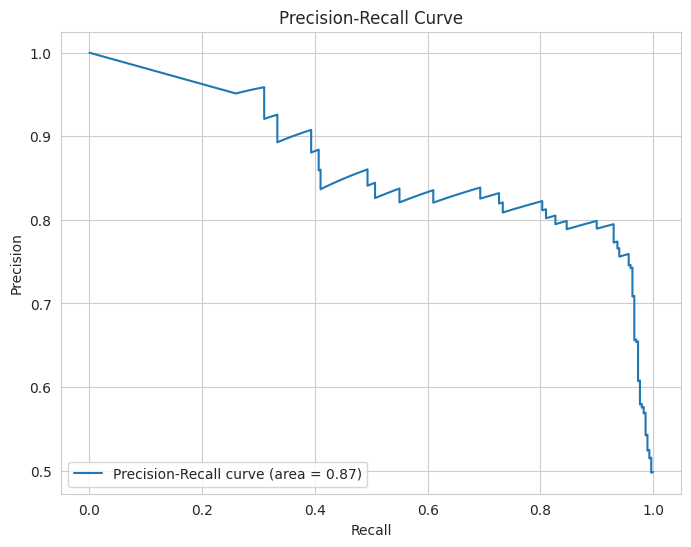

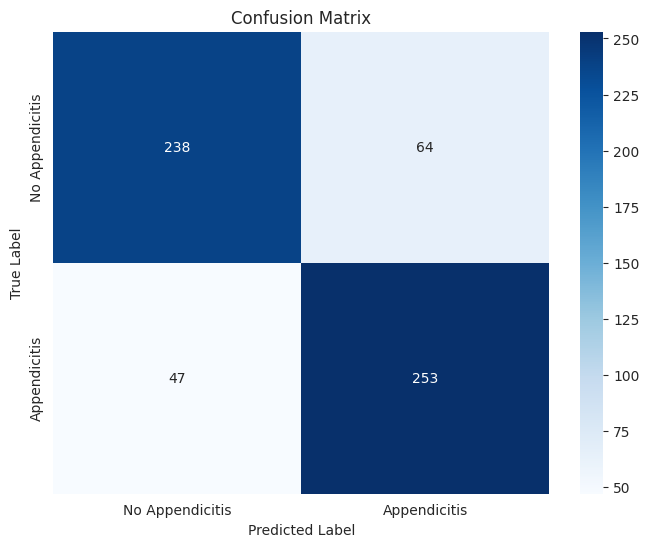

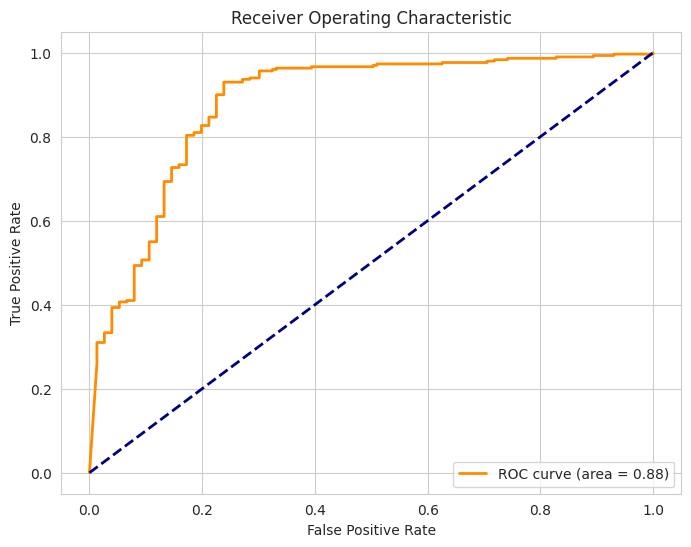

In [55]:
from sklearn.metrics import precision_recall_curve, auc

model.eval()
from sklearn.metrics import roc_curve

# Lists to store predictions, ground truth labels, and filenames
all_probabilities = []
all_predictions = []
all_labels = []
all_filenames = []
all_outputs = []

# Iterate over the validation dataset
for images, labels, filenames in val_loader:
    with torch.no_grad():  # No need to compute gradients during inference
        outputs = model(images)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get the predicted class indices
        probabilities = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Get probabilities for class 1

        # Store predictions, labels, filenames, and outputs
        all_probabilities.extend(probabilities.tolist())
        all_predictions.extend(predicted.tolist())
        all_labels.extend(labels.tolist())
        all_filenames.extend(filenames)
        all_outputs.extend(outputs.tolist())

# Convert predictions and labels to numpy arrays for further analysis if needed
all_probabilities = np.array(all_probabilities)
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate accuracy
accuracy = np.mean(all_predictions == all_labels)
print(f'Validation Accuracy: {accuracy}')

# Compute ROC AUC Score
roc_auc = roc_auc_score(all_labels, all_probabilities)
print(f'ROC AUC Score: {roc_auc}')

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)

# Define class labels
class_labels = ['No Appendicitis', 'Appendicitis']
# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

precision, recall, _ = precision_recall_curve(all_labels, all_probabilities)
pr_auc = auc(recall, precision)

# You can plot these values to visualize the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Plot confusion matrix with labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Store each prediction along with filenames and outputs
predictions_data = []
for i in range(len(all_predictions)):
    predictions_data.append({'Filename': all_filenames[i],
                             'Ground Truth': all_labels[i],
                             'Prediction': all_predictions[i],
                             'Output': all_outputs[i]})
predictions_df = pd.DataFrame(predictions_data)
# print(predictions_df)